In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms
from torch.autograd import Variable
from tqdm import tqdm
import csv
from torchsummary import summary
import torchvision


In [3]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,5,1)
        nn.init.kaiming_normal_(self.conv1.weight) # Weight initialization
        self.conv2 = nn.Conv2d(32,32,3,1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.conv3 = nn.Conv2d(32,64,1,1)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.conv4 = nn.Conv2d(64,64,3,1)
        nn.init.kaiming_normal_(self.conv4.weight)
        
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4_bn = nn.BatchNorm2d(64)
        
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2_bn = nn.BatchNorm1d(43)

        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 43)
        
        self.dropout=nn.Dropout(0.2)

    def forward(self, x):
        
        x = F.relu(self.conv2_bn(self.conv2(F.relu(self.conv1_bn(self.conv1(x))))))
        x = self.pool(x)
        
        x = self.dropout(x)
        
        x = F.relu(self.conv4_bn(self.conv4(F.relu(self.conv3_bn(self.conv3(x))))))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.fc2(x)
    
        return x

In [4]:
# Classifying the cropped image with our custom CNN
# Returns the label (int)

def classify(Classification_model, img, xmin, ymin, xmax, ymax):
    
    # Cropping the image
    cropped = img[ymin:ymax,xmin:xmax,:]
    cropped=cv2.resize(cropped, (32,32), interpolation = cv2.INTER_AREA)
    

    # Preprocessing of the cropped image 
    prediction = []
    cropped = cropped.transpose(2, 0, 1)
    cropped = cropped.astype('float32') 
    cropped = cropped[None, :]
    
    inputs = torch.from_numpy(cropped/255)
    
    # Get the class of the cropped image
    Classification_model.eval()
    with torch.no_grad():
            outputs = Classification_model.forward(inputs.to(device)).detach().cpu().numpy()

    prediction.append(np.argmax(outputs, axis=1))
   

    prediction = np.hstack(prediction)
    return prediction

In [5]:
#Load saved detection model
Detection_model = torch.load(r'./FRCNN/train1000.pkl')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
Detection_model.to(device)
print("Detection Model loaded!")

#Load saved classification model
Classification_model = torch.load(r'./CNN2waug.pkl')

print("Classification Model loaded!")

Detection Model loaded!
Classification Model loaded!


Label is: 9
===
(Xmin, Ymin, Xmax, Ymax) = (1359, 959, 1406, 1010) 
===
Class Label:  No passing


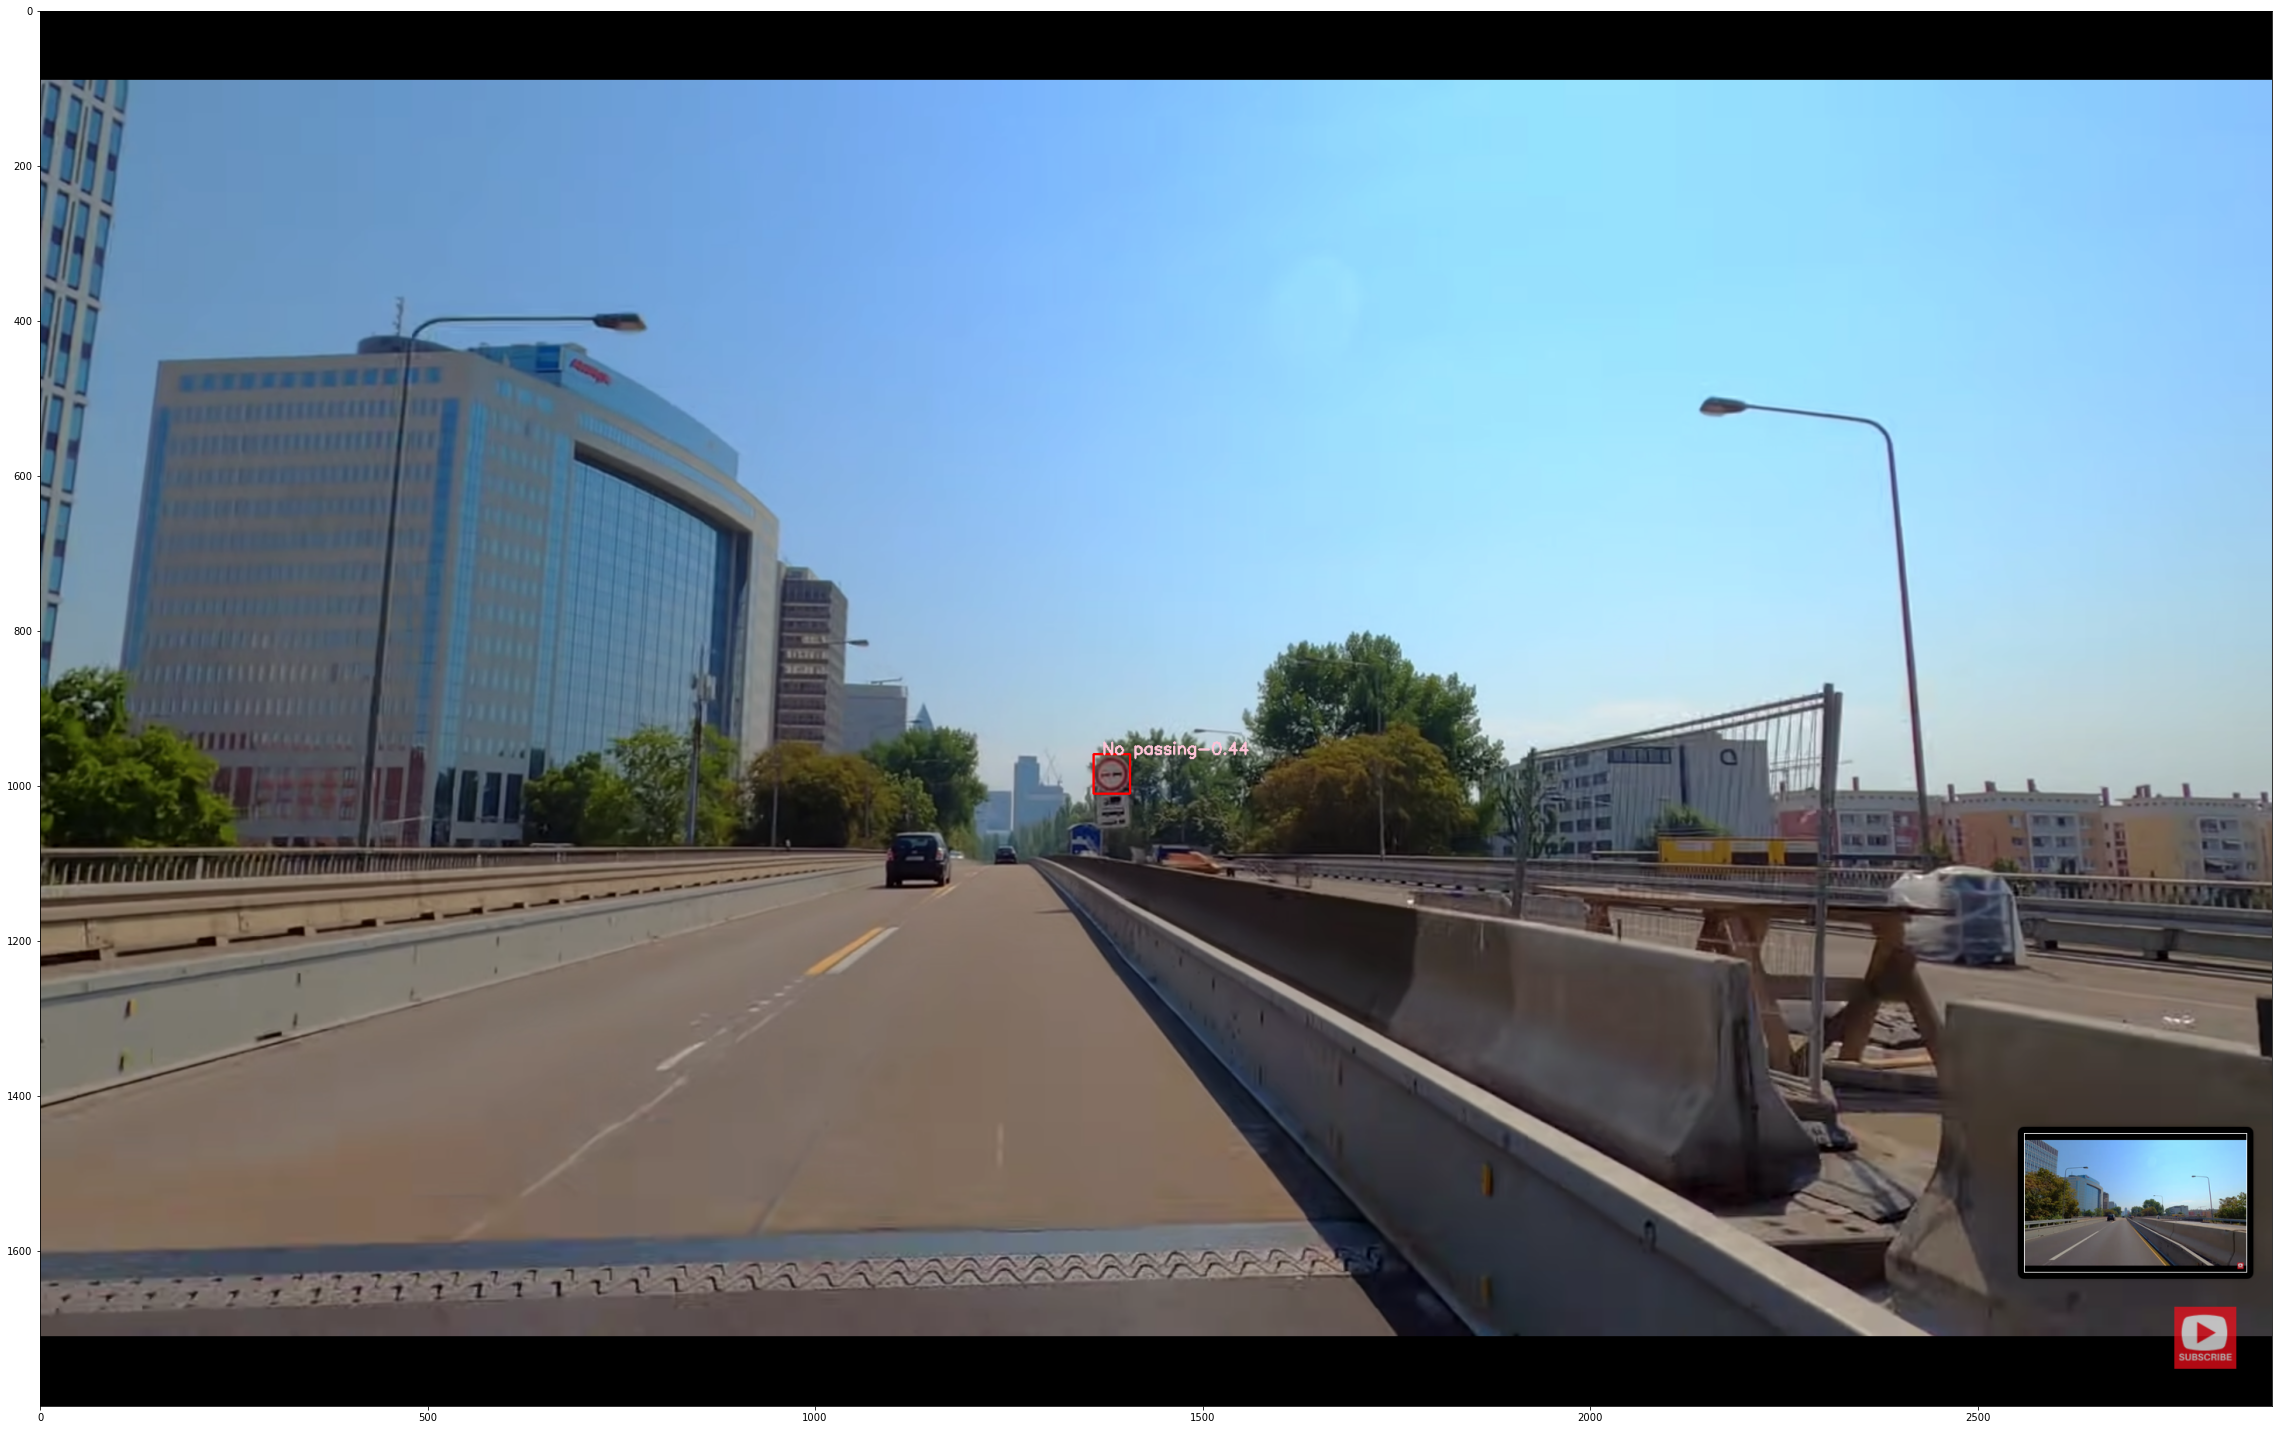

In [97]:
'''
Will show the full image with a bounding box and label predicted with our custom CNN model
'''
#Test the model:
# There are three test images in the folder, test1.png , test2.png. test3.png
img =cv2.imread('test3.png')

# Image pre-processing
img = img.transpose(2, 0, 1)
img=img.astype('float32')
img=torch.from_numpy(img/255)

Detection_model.eval()
with torch.no_grad():
        prediction = Detection_model.forward([img.to(device)])
        
b = prediction[0]['boxes']
s = prediction[0]['scores']
    
# Apply Non-maximum suppression:
keep = torchvision.ops.nms(b,s,0.1)

img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
img = np.array(img)  # tensor → ndarray

#Convert np array img to right format.
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Class number coressponding to Classes
classes = { 0:' Speed limit (20km/h)' ,
    1:' Speed limit (30km/h)' ,
    2:' Speed limit (50km/h)' ,
    3:' Speed limit (60km/h)' ,
    4:' Speed limit (70km/h)' ,
    5:' Speed limit (80km/h)' ,
    6:' End of speed limit (80km/h)' ,
    7:' Speed limit (100km/h)' ,
    8:' Speed limit (120km/h)' ,
    9:' No passing' ,
    10:' No passing veh over 3.5 tons' ,
    11:' Right-of-way at intersection' ,
    12:' Priority road' ,
    13:' Yield' ,
    14:' Stop' ,
    15:' No vehicles' ,
    16:' Veh > 3.5 tons prohibited' ,
    17:' No entry' ,
    18:' General caution' ,
    19:' Dangerous curve left' ,
    20:' Dangerous curve right' ,
    21:' Double curve' ,
    22:' Bumpy road' ,
    23:' Slippery road' ,
    24:' Road narrows on the right' ,
    25:' Road work' ,
    26:' Traffic signals' ,
    27:' Pedestrians' ,
    28:' Children crossing' ,
    29:' Bicycles crossing' ,
    30:' Beware of ice/snow' ,
    31:' Wild animals crossing' ,
    32:' End speed + passing limits' ,
    33:' Turn right ahead' ,
    34:' Turn left ahead' ,
    35:' Ahead only' ,
    36:' Go straight or right' ,
    37:' Go straight or left' ,
    38:' Keep right' ,
    39:' Keep left' ,
    40:' Roundabout mandatory' ,
    41:' End of no passing' ,
    42:' End no passing veh > 3.5 tons'  }


for k in range(len(keep)):
    xmin = round(prediction[0]['boxes'][k][0].item())
    ymin = round(prediction[0]['boxes'][k][1].item())
    xmax = round(prediction[0]['boxes'][k][2].item())
    ymax = round(prediction[0]['boxes'][k][3].item())
    
    # Default prediction
    labelRCNN = prediction[0]['labels'][k].item()
    
    # Label prediction with our model
    label = classify(Classification_model, img, xmin, ymin, xmax, ymax)[0]
    print("Label is: {}\n===\n(Xmin, Ymin, Xmax, Ymax) = ({}, {}, {}, {}) \n===".format(label, xmin, ymin, xmax, ymax))

    colors = np.random.uniform(0, 255, size=(43, 3))
    if label in classes:
        pt1 = (xmin, ymin)
        pt2 = (xmax, ymax)
        print("Class Label: "+ classes[label])
        score = prediction[0]['scores'][k].item()
        color = list(colors[label])
        cv2.rectangle(img, pt1, pt2, color[0], thickness=2)
        cv2.putText(img, classes[label]+"-"+str(round(score,2)), (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color,
                        thickness=2)



plt.figure(figsize=(40,35))
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)